In [ ]:
#Pretrained word2vec embeddings

In [1]:
#from torchtext import data
#from torchtext import datasets
import torch
import spacy
import random
import numpy as np
import pandas as pd
import time
import re # for regular expressions
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import spacy
nlp = spacy.load('en')

data =  pd.read_csv('transferlearning-dl-spring2020/train.csv')

data.head()

questions = data['text']
labels = data['target']

train_data, valid_data, ytrain, yvalid = train_test_split(questions, labels,  
                                                          random_state=42, 
                                                          test_size=0.2)

train_data.head()



251      @USER All you need to know is he is empty inside
3720                            @USER I. AM. READ. E! URL
8376    @USER Go roger I quit watching anyway nfl is o...
4471               @USER Yoo our dogs should totally fuck
2835              @USER He is a troll.  Not open to facts
Name: text, dtype: object

In [2]:
data.head()

,id,text,target
0,86426,@USER She should ask a few native Americans wh...,1
1,16820,Amazon is investigating Chinese employees who ...,0
2,62688,"@USER Someone should'veTaken"" this piece of sh...",1
3,43605,@USER @USER Obama wanted liberals &amp; illega...,0
4,97670,@USER Liberals are all Kookoo !!!,1


In [ ]:

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

data['text'] = np.vectorize(remove_pattern)(data['text'], "@[\w]*") 

data['text'] = data['text'].str.replace("[^a-zA-Z#]", " ")

data['text'] = data['text'].str.replace('#','')

data['text'] = data['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

tokenized_tweet = data['text'].apply(lambda x: x.split()) # tokenizing

tokenized_tweet.head()

len(tokenized_tweet)

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x]) # stemming


In [ ]:
tokenized_tweet[1:10]

In [8]:
# Using pre-trained word2vec embeddings created by Google

import gensim

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

#model.train(tokenized_tweet, total_examples= len(combi['description']), epochs=50)

def word_vector_pretrained(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

wordvec_arrays = np.zeros((len(tokenized_tweet), 300))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector_pretrained(tokenized_tweet[i], 300)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape    

X_train, X_test , y_train, y_test = train_test_split(wordvec_df, labels, test_size=0.2, random_state=1)



In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [13]:
lreg = LogisticRegression(random_state = 10)
lreg.fit(X_train, y_train) # training the model

prediction = lreg.predict(X_test) # predicting on the validation set

prediction_int = prediction.astype(np.int)

f1_score(y_test, prediction,average = 'macro') # calculating f1 score

0.6691278341911253

In [14]:
data_test =  pd.read_csv('transferlearning-dl-spring2020/test.csv')

In [ ]:
data_test['text'] = np.vectorize(remove_pattern)(data_test['text'], "@[\w]*") 

data_test['text'] = data_test['text'].str.replace("[^a-zA-Z#]", " ")

data_test['text'] = data_test['text'].str.replace('#','')

data_test['text'] = data_test['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

tokenized_tweet_test = data_test['text'].apply(lambda x: x.split()) # tokenizing

tokenized_tweet_test.head()

len(tokenized_tweet_test)

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
tokenized_tweet_test.apply(lambda x: [lemmatizer.lemmatize(i) for i in x]) # stemming


In [16]:

wordvec_arrays_test = np.zeros((len(tokenized_tweet_test), 300))

for i in range(len(tokenized_tweet_test)):
    wordvec_arrays_test[i,:] = word_vector_pretrained(tokenized_tweet_test[i], 300)
    
wordvec_df_test = pd.DataFrame(wordvec_arrays_test)
wordvec_df_test.shape    


(3894, 300)

In [17]:
X_test1 = np.array(wordvec_df_test)

prediction1 = lreg.predict(X_test1) # predicting on the validation set

prediction_int1 = prediction1.astype(np.int)

In [18]:
prediction_int1

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
data_test['Target'] = prediction_int1
submission = data_test[['id','Target']]
submission.to_csv('pretrained_word2vec.csv', index=False) # writing data to a CSV file
submission

In [ ]:
# Fine tuned word2vec 

In [56]:
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=50, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(tokenized_tweet), epochs=200)

def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

wordvec_arrays = np.zeros((len(tokenized_tweet), 50))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 50)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape    


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(9346, 50)

In [58]:
X_train, X_test , y_train, y_test = train_test_split(wordvec_df, labels, test_size=0.2, random_state=1)

lreg = LogisticRegression(random_state = 20)
lreg.fit(X_train, y_train) # training the model

prediction = lreg.predict(X_test) # predicting on the validation set

prediction_int = prediction.astype(np.int)

f1_score(y_test, prediction,average = 'macro') # calculating f1 score

0.5291078614322713

In [ ]:
# CNN for text classification 

In [60]:
top_data_df_small = data

In [61]:
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']] 
print(top_data_df_small['tokenized_text'].head(10))

0    [she, should, ask, few, native, americans, wha...
1    [amazon, investigating, chinese, employees, wh...
2    [someone, should, vetaken, this, piece, shit, ...
3    [obama, wanted, liberals, amp, illegals, move,...
4                         [liberals, are, all, kookoo]
5    [was, literally, just, talking, about, this, l...
6                                [buy, more, icecream]
7             [not, fault, you, support, gun, control]
8    [what, the, difference, between, kavanaugh, an...
9    [you, are, lying, corrupt, traitor, nobody, wa...
Name: tokenized_text, dtype: object


In [62]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
top_data_df_small['stemmed_tokens'].head(10)

0    [she, should, ask, few, nativ, american, what,...
1    [amazon, investig, chines, employe, who, ar, s...
2    [someon, should, vetaken, thi, piec, shit, vol...
3    [obama, want, liber, amp, illeg, move, into, r...
4                             [liber, ar, all, kookoo]
5    [wa, liter, just, talk, about, thi, lol, all, ...
6                                [bui, more, icecream]
7             [not, fault, you, support, gun, control]
8    [what, the, differ, between, kavanaugh, and, o...
9    [you, ar, ly, corrupt, traitor, nobodi, want, ...
Name: stemmed_tokens, dtype: object

In [63]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[[ 'text',  'stemmed_tokens']], 
                                                        top_data_df_small['target'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

Value counts for Train sentiments
0    4365
1    2177
Name: target, dtype: int64
Value counts for Test sentiments
0    1855
1     949
Name: target, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                               text  \
0   8030                          least you are honest lmao   
1   3722                         All that shit was hers URL   
2   3522                         Cutie connection authentic   
3   4232  What interview Evanne honest and right from th...   
4   1678  Warriorscoach fundraising for gun control Brad...   

                                      stemmed_tokens  
0                     [least, you, ar, honest, lmao]  
1                    [all, that, shit, wa, her, url]  
2                           [cuti, connect, authent]  
3  [what, interview, evann, honest, and, right, f...  
4  [warriorscoach, fundrais, for, gun, control, b...  


In [64]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [67]:
from gensim.models import Word2Vec
size = 500
window = 3
min_count = 1
workers = 3
sg = 1

# Function to train word2vec model
def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file =   'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = top_data_df_small['stemmed_tokens']
        word2vec_file =   'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(top_data_df_small, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

9346


In [68]:
# Function to get the output tensor
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [71]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10
import gensim

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load( 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [73]:
max_sen_len = top_data_df_small.stemmed_tokens.map(len).max()
padding_idx = w2vmodel.wv.vocab['pad'].index
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
            print(word)
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [74]:
NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.vocab)

cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 30

# Open the file for writing loss
loss_file_name = 'cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
cnn_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['target'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, 'cnn_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

Epoch1
Epoch ran :1
Epoch2
Epoch ran :2
Epoch3
Epoch ran :3
Epoch4
Epoch ran :4
Epoch5
Epoch ran :5
Epoch6
Epoch ran :6
Epoch7
Epoch ran :7
Epoch8
Epoch ran :8
Epoch9
Epoch ran :9
Epoch10
Epoch ran :10
Epoch11
Epoch ran :11
Epoch12
Epoch ran :12
Epoch13
Epoch ran :13
Epoch14
Epoch ran :14
Epoch15
Epoch ran :15
Epoch16
Epoch ran :16
Epoch17
Epoch ran :17
Epoch18
Epoch ran :18
Epoch19
Epoch ran :19
Epoch20
Epoch ran :20
Epoch21
Epoch ran :21
Epoch22
Epoch ran :22
Epoch23
Epoch ran :23
Epoch24
Epoch ran :24
Epoch25
Epoch ran :25
Epoch26
Epoch ran :26
Epoch27
Epoch ran :27
Epoch28
Epoch ran :28
Epoch29
Epoch ran :29
Epoch30
Epoch ran :30
Input vector
[[  235    13    16     0   928   172   358   244     7     7 10887 10887
  10887 10887 10887 10887 10887 10887 10887 10887 10887 10887 10887 10887
  10887 10887 10887 10887 10887 10887 10887 10887 10887 10887 10887 10887
  10887 10887 10887 10887 10887 10887 10887 10887 10887 10887 10887 10887
  10887]]
Probs
tensor([[1.1411e-11, 9.5633e-01, 

In [79]:
from sklearn.metrics import classification_report
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
loss_df = pd.read_csv('cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        original_lables_cnn_bow.append(make_target(Y_test['target'][index]).cpu().numpy()[0])
        
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = 'cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig('loss_plt_500_padding_30_epochs.pdf')

Index(['iter', ' loss'], dtype='object')


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.66      1.00      0.80      1855
           2       0.00      0.00      0.00       949

    accuracy                           0.66      2804
   macro avg       0.33      0.50      0.40      2804
weighted avg       0.44      0.66      0.53      2804

Index(['iter', ' loss'], dtype='object')


In [88]:
data_test =  pd.read_csv('transferlearning-dl-spring2020/test.csv')

In [89]:
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
data_test['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in data_test['text']] 
print(data_test['tokenized_text'].head(10))

0    [user, user, go, home, you, re, drunk, user, m...
1                  [user, user, oh, noes, tough, shit]
2    [user, canada, doesn, need, another, cuck, we,...
3    [user, user, user, it, should, scare, every, a...
4    [user, user, user, user, lol, throwing, the, b...
5                      [user, user, you, are, correct]
6    [user, user, kind, of, like, when, conservativ...
7    [the, only, thing, the, democrats, have, is, l...
8    [user, user, user, user, user, user, user, use...
9    [user, user, user, user, user, user, user, use...
Name: tokenized_text, dtype: object


In [90]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
data_test['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in data_test['tokenized_text'] ]
data_test['stemmed_tokens'].head(10)

0    [user, user, go, home, you, re, drunk, user, m...
1                   [user, user, oh, noe, tough, shit]
2    [user, canada, doesn, need, anoth, cuck, we, a...
3    [user, user, user, it, should, scare, everi, a...
4    [user, user, user, user, lol, throw, the, bull...
5                       [user, user, you, ar, correct]
6    [user, user, kind, of, like, when, conserv, wa...
7    [the, onli, thing, the, democrat, have, is, ly...
8    [user, user, user, user, user, user, user, use...
9    [user, user, user, user, user, user, user, use...
Name: stemmed_tokens, dtype: object

In [92]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(top_data_df_small, test_size=1, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[[ 'text',  'stemmed_tokens']], 
                                                        top_data_df_small['target'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_test = data_test[[ 'text',  'stemmed_tokens']]

In [93]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [94]:
from gensim.models import Word2Vec
size = 500
window = 3
min_count = 1
workers = 3
sg = 1

# Function to train word2vec model
def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file =   'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = top_data_df_small['stemmed_tokens']
        word2vec_file =   'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(X_test, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

3894


In [97]:
max_sen_len = X_test.stemmed_tokens.map(len).max()
padding_idx = w2vmodel.wv.vocab['pad'].index
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
            print(word)
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

from sklearn.metrics import classification_report
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
#loss_df = pd.read_csv('cnn_class_big_loss_with_padding.csv')
#print(loss_df.columns)
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
#        original_lables_cnn_bow.append(make_target(Y_test['target'][index]).cpu().numpy()[0])
        
#print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
#loss_file_name = 'cnn_class_big_loss_with_padding.csv'
#loss_df = pd.read_csv(loss_file_name)
#print(loss_df.columns)
#plt_500_padding_30_epochs = loss_df[' loss'].plot()
#fig = plt_500_padding_30_epochs.get_figure()
#fig.savefig('loss_plt_500_padding_30_epochs.pdf')

In [ ]:
data_test['Target'] = bow_cnn_predictions
submission = data_test[['id','Target']]
submission.to_csv('cnn.csv', index=False) # writing data to a CSV file
submission

In [ ]:
# LSTM for text classification 

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [167]:
df = data
df.head()

,id,text,target,tokenized_text,stemmed_tokens
0,86426,She should ask few native Americans what their...,1,"[she, should, ask, few, native, americans, wha...","[she, should, ask, few, nativ, american, what,..."
1,16820,Amazon investigating Chinese employees who are...,0,"[amazon, investigating, chinese, employees, wh...","[amazon, investig, chines, employe, who, ar, s..."
2,62688,Someone should veTaken this piece shit volcano,1,"[someone, should, vetaken, this, piece, shit, ...","[someon, should, vetaken, thi, piec, shit, vol..."
3,43605,Obama wanted liberals amp illegals move into r...,0,"[obama, wanted, liberals, amp, illegals, move,...","[obama, want, liber, amp, illeg, move, into, r..."
4,97670,Liberals are all Kookoo,1,"[liberals, are, all, kookoo]","[liber, ar, all, kookoo]"


In [168]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9346 entries, 0 to 9345
Data columns (total 5 columns):
id                9346 non-null int64
text              9346 non-null object
target            9346 non-null int64
tokenized_text    9346 non-null object
stemmed_tokens    9346 non-null object
dtypes: int64(2), object(3)
memory usage: 365.2+ KB


Text(0.5, 1.0, 'Number of positive and negative messages')

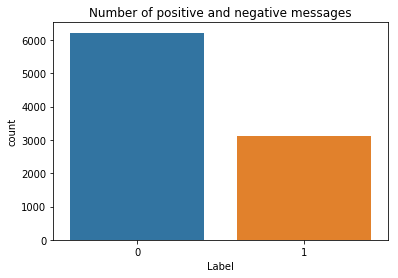

In [169]:
sns.countplot(df.target)
plt.xlabel('Label')
plt.title('Number of positive and negative messages')

In [ ]:
# Bi-directional RNN for text classification

In [29]:
wordvec_df.shape

(9346, 200)

In [43]:
import torch   

#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [46]:
#loading custom dataset
training_data=data

#print preprocessed text
print(vars(training_data[0:1]))

{'_is_copy': <weakref at 0x1a30693f98; to 'DataFrame' at 0x1a30555a20>, '_data': BlockManager
Items: Index(['id', 'text', 'target'], dtype='object')
Axis 1: RangeIndex(start=0, stop=1, step=1)
IntBlock: slice(0, 4, 2), 2 x 1, dtype: int64
ObjectBlock: slice(1, 2, 1), 1 x 1, dtype: object, '_item_cache': {}}


In [49]:
import random
train_data,X_test, valid_data,Y_test = train_test_split(training_data['text'],training_data['target'],test_size=0.2)

In [50]:
# LSTM for text classification 

In [118]:
# LSTM for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000

X = data.text
Y = data.target
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2) 

max_words = 1000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(sequences,maxlen=max_len)
print(X_train.shape)
print(y_train.shape)
#X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
#X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_len))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, Y_train, epochs=10, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

(7476, 200)
(25000,)
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 200, 32)           160000    
_________________________________________________________________
lstm_29 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
7476/7476 [==============================] - 120s 16ms/step - loss: 0.6291 - accuracy: 0.6651
Epoch 2/10
7476/7476 [==============================] - 112s 15ms/step - loss: 0.5440 - accuracy: 0.7289
Epoch 3/10
7476/7476 [==============================] - 113s 15ms/step - loss: 0.4807 - accuracy: 0.7746
Epoch 4/10
7476/7476 [==============

ValueError: Error when checking input: expected embedding_22_input to have shape (200,) but got array with shape (1,)

In [120]:
#tok.fit_on_texts(X_)
sequences = tok.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(sequences,maxlen=max_len)


scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 71.98%


In [ ]:
test_sequences = tok.texts_to_sequences(data_test['text'])
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

test_sequences_matrix.shape

pred = model.predict(test_sequences_matrix)

predicted = []
for i in range(len(pred)):
    if pred[i] >= 0.5:
        predicted += [1]
    else:
        predicted += [0]

data_test['Target'] = predicted
submission = data_test[['id','Target']]
submission.to_csv('lstm2.csv', index=False) # writing data to a CSV file
submission



In [89]:
# LSTM For text Classification With Dropout

In [ ]:
# LSTM with Dropout for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000

X = data.text
Y = data.target
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2) 

max_words = 1000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(sequences,maxlen=max_len)
print(X_train.shape)
print(y_train.shape)


# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_len))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=20, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

(7476, 200)
(7476,)
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 200, 32)           160000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 32)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
7476/7476 [==============================] - 113s 15ms/step - loss: 0.6294 - 

In [ ]:
#tok.fit_on_texts(X_)
sequences = tok.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(sequences,maxlen=max_len)


scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

test_sequences = tok.texts_to_sequences(data_test['text'])
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

test_sequences_matrix.shape

pred = model.predict(test_sequences_matrix)

predicted = []
for i in range(len(pred)):
    if pred[i] >= 0.5:
        predicted += [1]
    else:
        predicted += [0]

data_test['Target'] = predicted
submission = data_test[['id','Target']]
submission.to_csv('lstm2.csv', index=False) # writing data to a CSV file
submission


In [ ]:
# LSTM and Convolutional Neural Network For Sequence Classification

In [ ]:
# LSTM and CNN for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
X_train,X_test,y_train,y_test = train_test_split(data['text'],data['target'],test_size=0.2) 
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
#tok.fit_on_texts(X_)
sequences = tok.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(sequences,maxlen=max_len)


scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

test_sequences = tok.texts_to_sequences(data_test['text'])
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

test_sequences_matrix.shape

pred = model.predict(test_sequences_matrix)

predicted = []
for i in range(len(pred)):
    if pred[i] >= 0.5:
        predicted += [1]
    else:
        predicted += [0]

data_test['Target'] = predicted
submission = data_test[['id','Target']]
submission.to_csv('lstm2.csv', index=False) # writing data to a CSV file
submission



In [ ]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 1)
	y = y.reshape(1, n_timesteps, 1)
	return X, y

# define problem properties
n_timesteps = 10
# define LSTM
model = Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# train LSTM
for epoch in range(1000):
	# generate new random sequence
	X,y = get_sequence(n_timesteps)
	# fit model for one epoch on this sequence
	model.fit(X, y, epochs=1, batch_size=1, verbose=2)
# evaluate LSTM
X,y = get_sequence(n_timesteps)
yhat = model.predict_classes(X, verbose=0)
for i in range(n_timesteps):
	print('Expected:', y[0, i], 'Predicted', yhat[0, i])

In [ ]:
#tok.fit_on_texts(X_)
sequences = tok.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(sequences,maxlen=max_len)


scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

test_sequences = tok.texts_to_sequences(data_test['text'])
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

test_sequences_matrix.shape

pred = model.predict(test_sequences_matrix)

predicted = []
for i in range(len(pred)):
    if pred[i] >= 0.5:
        predicted += [1]
    else:
        predicted += [0]

data_test['Target'] = predicted
submission = data_test[['id','Target']]
submission.to_csv('lstm2.csv', index=False) # writing data to a CSV file
submission


